# Author

***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-08-22**

# Code

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob
from pickle import dump, load
from time import time, perf_counter
import random
import os
import string
from textwrap import wrap
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                        Activation, Flatten, Reshape, concatenate, \
                        Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change directory to folder containing datasets

%cd /content/drive/MyDrive/AI training by HST/RNN

# list all files or folders (directories)
!ls

/content/drive/MyDrive/AI training by HST/RNN
Caption_Generator.ipynb  Flickr8k  glove.6B.zip  model.png	 test.npy
descriptions.txt	 glove.6B  model.h5	 NLP_LSTM.ipynb  train.npy


# Load resources

In [4]:
# read file
def load_file(filepath):
  file = open(filepath, 'r')
  text = file.read()
  file.close()
  return text 

def load_data(data_path):
  temp = load_file(data_path).split('\n')
  images = []
  captions = []
  for line in temp:
    if len(line) < 1:
      continue
    a = line.split()
    images.append(a[0])
    captions.append(' '.join(a[1:]))
  

  return pd.DataFrame({'image': images, 'caption': captions})

# read image
def load_labels(filepath):
  f = load_file(filepath)
  dataset = []
  for line in f.split('\n'):
    if len(line) < 1:
      continue

    dataset.append(line)
  print(dataset[:5])
  return set(dataset)

def read_image(path):
  img = load_img(path,color_mode='rgb',target_size=(224, 224))
  img = img_to_array(img)
  img = img/255.
    
  return img


In [5]:
text_path = "Flickr8k/Flickr8k_text/Flickr8k.token.txt"
images_path = 'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
image_path = r'Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/'
train_labels_path = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_labels_path = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'

raw_data = load_file(text_path)
def load_descriptions(captions):
  target = dict()
  lines = captions.split('\n')
  for line in lines:
    token = line.split()
    if len(token) < 2:
      continue
    img_id, img_des = token[0][:-2], ' '.join(token[1:])
    if img_id not in target:
      target[img_id] = []
    target[img_id].append(img_des)
  return target

descriptions = load_descriptions(raw_data)
print(f'size of dictionary: {len(descriptions)}')

descriptions['3684518763_f3490b647a.jpg']

size of dictionary: 8092


['A guy in gold chains , a black top , and gold shorts is walking with his arms outstretched in a parade .',
 'A young man raises his arms as he marches in a parade .',
 'A young man with gold short shorts and a black top is walking in a parade .',
 'Man in gold jewelry and shorts by a parade .',
 'The man in the gold lame shorts is wearing many gold necklaces .']

In [6]:
left_padding = len(images_path)
# img is list of full path names of all images
imgs = glob.glob(images_path + '*.jpg')

temp_train_labels = set(open(train_labels_path, 'r').read().strip().split('\n'))
temp_test_labels = set(open(test_labels_path, 'r').read().strip().split('\n'))

images = []
captions = []
for i in temp_train_labels:
  cpts = descriptions[i]
  for j in range(len(cpts)):
    images.append(i)
    captions.append(cpts[j])

df_train = pd.DataFrame({'image': images, 'caption': captions})

del images
del captions

images = []
captions = []
for i in temp_test_labels:
  cpts = descriptions[i]
  for j in range(len(cpts)):
    images.append(i)
    captions.append(cpts[j])

df_test = pd.DataFrame({'image': images, 'caption': captions})


In [7]:
train_labels = df_train['image'].unique()
test_labels = df_test['image'].unique()

In [8]:
df_train.head(5)

,image,caption
0,3582920844_2742804f3d.jpg,A long haired mail is swinging his wet hair ar...
1,3582920844_2742804f3d.jpg,A long haired man in the water is swinging his...
2,3582920844_2742804f3d.jpg,A man wading in a lake dips his long hair into...
3,3582920844_2742804f3d.jpg,A person in the water .
4,3582920844_2742804f3d.jpg,A woman flips her hair full of water and spray...


## !Block, shouldn't run these cells

In [ ]:
train_images = [read_image(images_path + i) for i in train_labels]
test_images = [read_image(images_path + i) for i in test_labels]

with open('train.npy', 'wb') as f:
    np.save(f, train_images)
    
with open('test.npy', 'wb') as f:
    np.save(f, test_images)

## Run this cell

In [9]:
with open('train.npy', 'rb') as f:
    train_images = np.load(f)
    
with open('test.npy', 'rb') as f:
    test_images = np.load(f)

In [10]:
train_images.shape

(6000, 224, 224, 3)

In [11]:
test_images.shape

(1000, 224, 224, 3)

In [12]:
descriptions[train_labels[1]]

['A man in a hat and sunglasses reads a book on a park bench .',
 'A man in c camouflage cap and jeans is sitting on a bench reading a book .',
 'A man is sitting on a bench and reading a book .',
 'A man on a park bench reads a novel .',
 'A man wearing a camouflage hat and sunglasses reading a book on a black metal bench .']

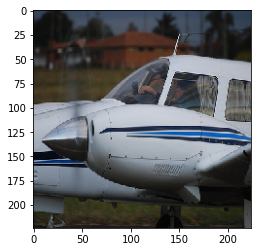

In [13]:
plt.imshow(read_image('Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3682428916_69ce66d375.jpg'))

## Display sample images

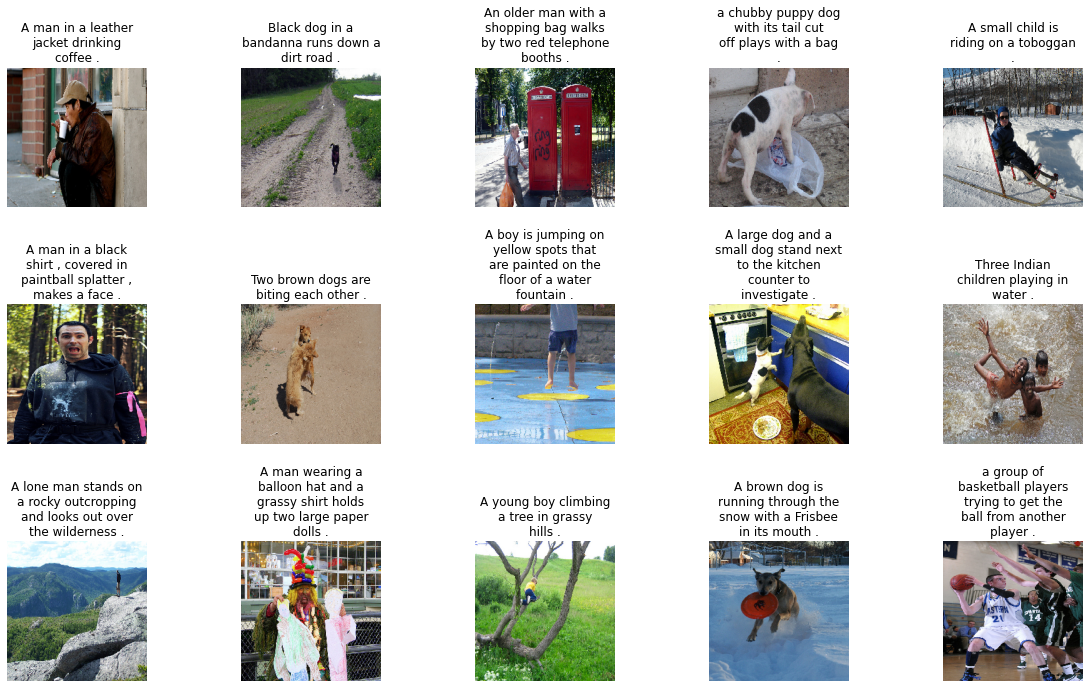

In [14]:
def display_images(df):
    df = df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = read_image(image_path + f"{df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(df.caption[i], 20)))
        plt.axis("off")

display_images(df_train.sample(15))

## Preprocessing text

In [15]:
def standardize_descriptions(data):
  # prepare translation table for removing punctuation
  translator = str.maketrans('', '', string.punctuation)
  data['caption'] = data['caption'].str.replace('[^\w\s]','')
  data['caption'] = data['caption'].apply(lambda x: x.lower())
  data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
  data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
  data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
  data['caption'] = "startseq "+data['caption']+" endseq"
  return data
  # for key, des_list in descriptions.items():
  #   for i in range(len(des_list)):
  #     des = des_list[i].split()
  #     # convert to lower case
  #     des = [word.lower() for word in des]
  #     # remove punctuation from each token
  #     des = [w.translate(translator) for w in des]
  #     # remove hanging 's' and 'a'
  #     des = [word for word in des if len(word) > 1]
  #     # remove tokens with numbers in them
  #     des = [word for word in des if word.isalpha()]
  #     # store as string
  #     des_list[i] = 'startstr ' + ' '.join(des) + ' endstr'
# clean descriptions
data_train = standardize_descriptions(df_train)
data_test = standardize_descriptions(df_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [16]:
data_train.head(5)

,image,caption
0,3582920844_2742804f3d.jpg,startseq long haired mail is swinging his wet ...
1,3582920844_2742804f3d.jpg,startseq long haired man in the water is swing...
2,3582920844_2742804f3d.jpg,startseq man wading in lake dips his long hair...
3,3582920844_2742804f3d.jpg,startseq person in the water endseq
4,3582920844_2742804f3d.jpg,startseq woman flips her hair full of water an...


In [17]:
captions = data_train['caption'].to_list()
captions.extend(data_test['caption'].to_list())
captions[:10]

['startseq long haired mail is swinging his wet hair around in the ocean endseq',
 'startseq long haired man in the water is swinging his head causing the water to spray in spiral endseq',
 'startseq man wading in lake dips his long hair into the water and quickly throws his head back making brief rainbow of water overhear endseq',
 'startseq person in the water endseq',
 'startseq woman flips her hair full of water and sprays the water all around endseq',
 'startseq man in hat and sunglasses reads book on park bench endseq',
 'startseq man in camouflage cap and jeans is sitting on bench reading book endseq',
 'startseq man is sitting on bench and reading book endseq',
 'startseq man on park bench reads novel endseq',
 'startseq man wearing camouflage hat and sunglasses reading book on black metal bench endseq']

In [18]:
# make dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data_train['image'].unique().tolist()
n_imgs = len(images)

split_index = round(0.88*n_imgs)
train_images = images[:split_index]
valid_images = images[split_index:]

train = data_train[data_train['image'].isin(train_images)]
vald = data_train[data_train['image'].isin(valid_images)]
test = data_test

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 192, 323, 10, 3, 4, 23, 6, 309, 28, 165, 2735, 4, 23, 19, 804, 3, 3137, 2]

In [19]:
vald.shape

(3600, 2)

## Preprocessing image

In [20]:
pretrained_model = ResNet50V2()


102883328/102869336 [==============================] - 1s 0us/step


In [21]:
!pwd

/content/drive/MyDrive/AI training by HST/RNN


In [22]:
fe = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm.tqdm(data_train['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 6000/6000 [51:32<00:00,  1.94it/s]


# Model

In [23]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [24]:
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

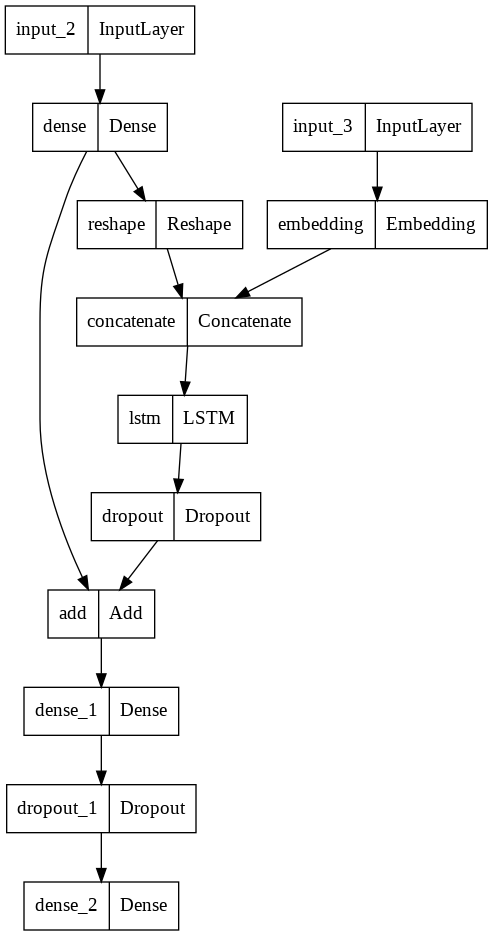

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [26]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=vald,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [27]:
model_name = "model.h5"

# checkpoint_filepath = '/tmp/checkpoint'
# checkpoint = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True, verbose=1)

# 'model-{epoch:03d}-{val_loss:.2f}.h5'

checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [28]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/50
160/412 [==========>...................] - ETA: 31:50 - loss: 5.8577

KeyboardInterrupt: ignored

In [ ]:
features['3064716525_b8418d4946.jpg'].shape

# Learning Curve

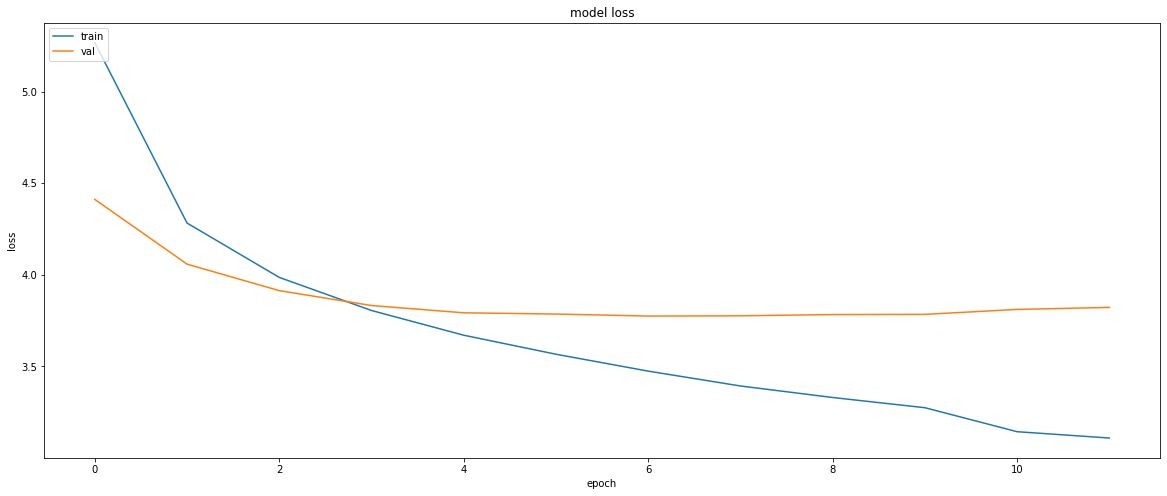

In [ ]:
# Learning Curve

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Caption Generation

In [ ]:
test_features = {}

for image in tqdm.tqdm(data_test['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    test_features[image] = feature

100%|██████████| 1000/1000 [01:44<00:00,  9.59it/s]


In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = test_features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

# Prediction

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)
samples

,image,caption
0,3387542157_81bfd00072.jpg,startseq athletic woman in red and white unifo...
1,751737218_b89839a311.jpg,startseq young boy splashing an older person w...
2,3223224391_be50bf4f43.jpg,startseq grey shaggy dog running endseq
3,2206960564_325ed0c7ae.jpg,startseq small puppy rungs towards the camera ...
4,3110649716_c17e14670e.jpg,startseq two men stand together one is putting...
5,3593392955_a4125087f6.jpg,startseq black and tan dog is running with whi...
6,2370481277_a3085614c9.jpg,startseq little boy in green is kicking soccer...
7,2078311270_f01c9eaf4c.jpg,startseq two women walking near some trees in ...
8,2197275664_fabcf3424b.jpg,startseq the little girl is riding her red sco...
9,1389264266_8170bc1c54.jpg,startseq girl with pink streaked hair and fur ...


In [ ]:
for index, record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

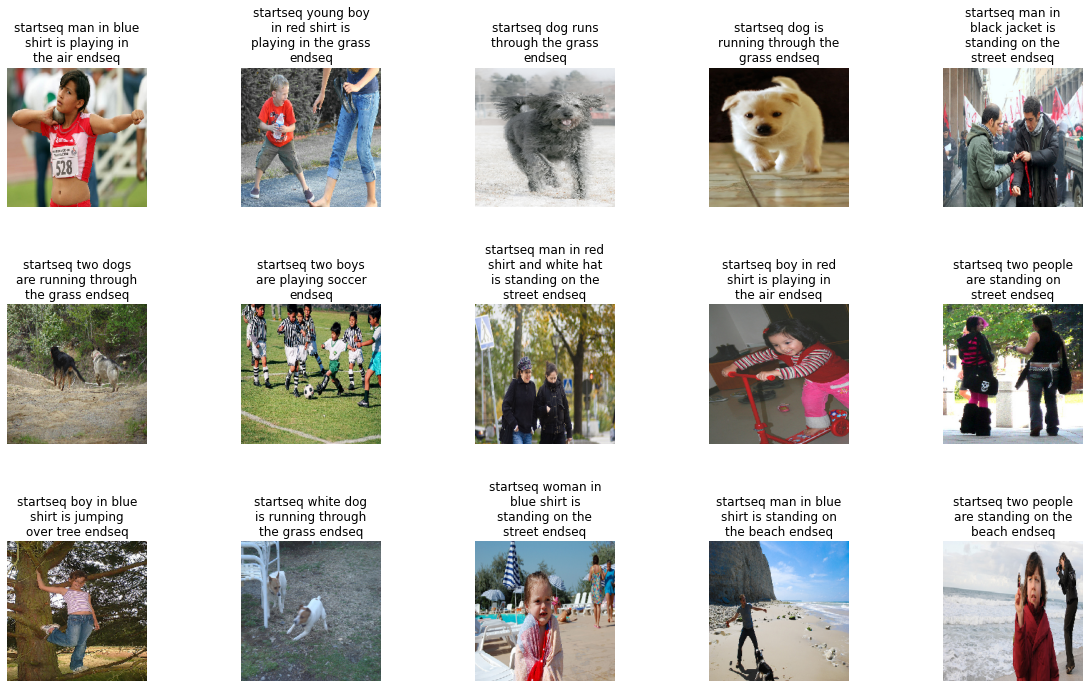

In [ ]:
display_images(samples)